# Библиотеки

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras.layers import Dense, Dropout # слои для ResNet
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from tensorflow.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.models import load_model #для загрузки модели
from tensorflow.keras.utils import plot_model #утилита построения архитектуры модели
from google.colab import files # Импортируем Модуль files для работы с файлами
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
import pandas as pd # Импортируем библиотеку pandas
from sklearn.model_selection import train_test_split
import time # Для расчёта времени выполнения кода ячейки
import random # Функция случайных значений
from google.colab import output # Для функции звукового сигнала выполнения кода ячейки
import os # Импортируем библиотеку os для работы с файловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
%matplotlib inline

In [ ]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Mounted at /content/drive


# Стартовый блок

In [ ]:
img_directory_path = '/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/photo_base_img/img'
segm_directory_path = '/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/photo_base_img_segm/img_segm'

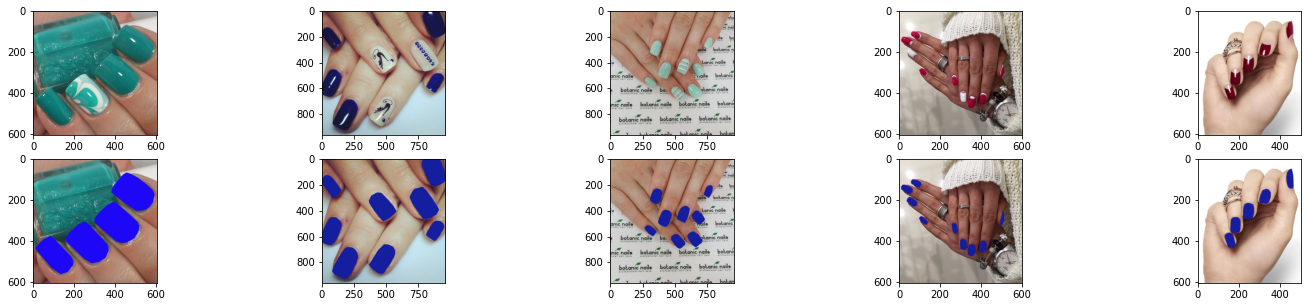

Минимальный размер изображание по x:  339
Минимальный размер изображание по y:  316


In [ ]:
# Нахождение минимальных размеров изображений по всему датасету, для приведения всех изображений обучающей и проверочной выборки к одному размеру
train_images = [] # Создаем пустой список для изображений обучающей выборки
train_segments = [] # Создаем пустой список для изображений проверочной выборки

list_segm_directory = [] #Список имён файлов сегментированных изображений, чтобы по нему взять исходные изображения из базы для обучающей выборки,
# т.к. сегм-х изобр-й меньше, чем весь набор изобр-й

for filename_segm_directory in sorted(os.listdir(segm_directory_path)): # Проходим по всем файлам в каталоге сегм-х изобр-й по указанному пути
    train_segments.append(image.load_img(os.path.join(segm_directory_path, filename_segm_directory))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size
    list_segm_directory.append(filename_segm_directory) # Список имён сегм-х изобр-й

for filename_train_directory in list_segm_directory: # Проходим по списку имён сегм-х изобр-й, находим изображения с таким же именем в каталоге изображений для обучающей выборки
    train_images.append(image.load_img(os.path.join(img_directory_path, filename_train_directory[:-5]+'.jpg'))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size

# Смотрим примеры изображений обучающей выборки и сегм-х изобр-й
n = 5 # Количество выводимых случайных изображений
fig, axs = plt.subplots(2, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  indexes = np.random.randint(0, len(train_images))
  axs[0, i].imshow(train_images[indexes]) # Отображаем фото
  axs[1, i].imshow(train_segments[indexes]) # Отображаем фото
plt.show() #Показываем изображения

# узнаём минимальные размеры изображений
list_x = [] # Список для значений по x
list_y = [] # Список для значений по y
for i in range(len(train_images)): # Проходим по изображениям обучающей выборки
  image_i = image.img_to_array(train_images[i]) # Переводим в numpy-массив
  list_x.append(image_i.shape[1]) # Отправляем количество строк в список для значений по x
  list_y.append(image_i.shape[0]) # Отправляем количество столбцов в список для значений по y
print('Минимальный размер изображание по x: ', min(list_x)) # Находим минимальное значение по x
print('Минимальный размер изображание по y: ', min(list_y)) # Находим минимальное значение по y

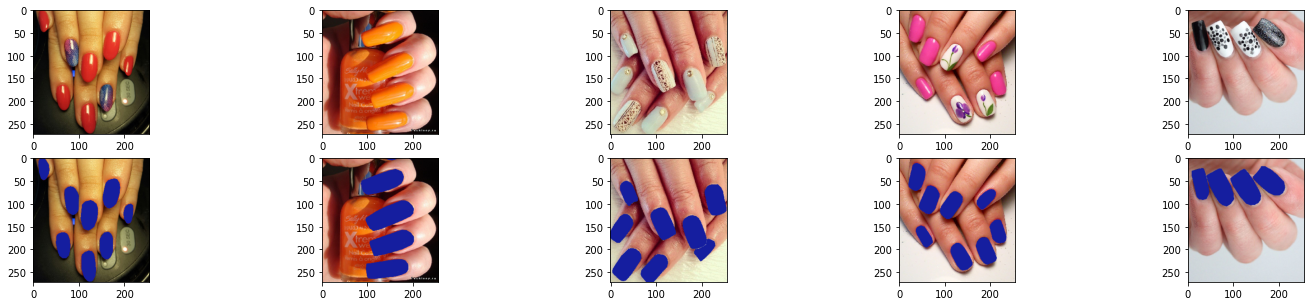

In [ ]:
# Задаём минимальные значения по x и y для обучения модели
img_width = 272
img_height= 256
num_classes = 2

#Загружаем снова изображения с фиксированным размером
train_images = [] # Перезаписываем список для изображений обучающей выборки
train_segments = [] # Перезаписываем список для изображений проверочной выборки

for filename_segm_directory in sorted(os.listdir(segm_directory_path)): # Проходим по всем файлам в каталоге по указанному пути
    train_segments.append(image.load_img(os.path.join(segm_directory_path, filename_segm_directory), target_size=(img_width, img_height))) # Читаем очередное изображение
#и добавляем ее в список изображения с указанным target_size

for filename_train_directory in list_segm_directory: # Проходим по всем файлам в каталоге по указанному пути
    train_images.append(image.load_img(os.path.join(img_directory_path, filename_train_directory[:-5]+'.jpg'), target_size=(img_width, img_height))) # Читаем очередное изображение
#и добавляем ее в список изображения с указанным target_size

# Смотрим полученные примеры изображений обучающей выборки и сегм-х изобр-й с фиксированным размером
n = 5 # Количество выводимых случайных изображений
fig, axs = plt.subplots(2, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  indexes = np.random.randint(0, len(train_images))
  axs[0, i].imshow(train_images[indexes]) # Отображаем фото
  axs[1, i].imshow(train_segments[indexes]) # Отображаем фото
plt.show() #Показываем изображения
beep()

In [ ]:
# Формируем xTrain
cur_time = time.time()
xTrain = [] # Создаем пустой список под обучающую выборку
for img in train_images:
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy
print(xTrain.shape) # Размерность обучающей выборки
print('Время обработки: ', round(time.time() - cur_time, 2),'c')
beep()

(443, 272, 256, 3)
Время обработки:  0.35 c


In [ ]:
# Функции для yTrain

# Функция преобразования пикселя сегментированного изображения в индекс (2 класса)
def color2index(color):
    index=0  # фон
    if (15<color[0]<25) and (25<color[1]<35)  and (150<color[2]<165) : index = 1 # область ногтей
    return index

# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes):
    y_shape = y.shape # Запоминаем форму массива для решейпа
    y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
    yt = [] # Создаем пустой лист
    for i in range(len(y)): # Проходим по всем трем каналам изображения
      yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
    yt = np.array(yt) # Преобразуем в numpy
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes) # Решейпим к исходому размеру
    return yt # Возвращаем сформированный массив

# Функция формирования yTrain
def yt_prep(data, num_classes):
    yTrain = [] # Создаем пустой список под карты сегметации
    for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
        y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
        y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
        yTrain.append(y) # Добавляем очередной элемент в yTrain
        if len(yTrain) % 100 == 0: # Каждые 100 шагов
            print(len(yTrain)) # Выводим количество обработанных изображений
    return np.array(yTrain) # Возвращаем сформированный yTrain

In [ ]:
# Формируем yTrain
cur_time = time.time()
yTrain = yt_prep(train_segments, num_classes)

In [ ]:
# Сохраняем на диске, чтобы при послеюдущих входах в ноутбук не формировать выборки заново
np.save('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/sampling/X_train', xTrain)
np.save('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/sampling/Y_train', yTrain)

## Аугментация

In [ ]:
# При новом вхождении в ноутбук загружаем выборки
X_train = np.load('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/sampling/X_train.npy')
Y_train = np.load('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/sampling/Y_train.npy')

In [ ]:
# Аугментация X_train
X_train_aug = [] # Список аугментации изображений X_train
for idx in range(len(X_train)): # Проходим по X_train
  ita_1 = image.img_to_array(Image.fromarray(X_train[idx].astype('uint8')).transpose(Image.FLIP_LEFT_RIGHT)) # Делаем зеркальное по горизонтали изображение
  X_train_aug.append(ita_1) # Добавляем в список аугментации изображений X_train
  ita_2 = image.img_to_array(Image.fromarray(X_train[idx].astype('uint8')).transpose(Image.FLIP_TOP_BOTTOM)) # Делаем зеркальное по вертикали изображение
  X_train_aug.append(ita_2) # Добавляем в список аугментации изображений X_train
X_train_aug = np.array(X_train_aug)

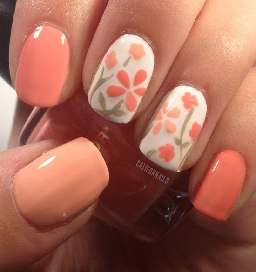

In [ ]:
img_aug = Image.fromarray(X_train[1].astype('uint8')) #Пример исходного изображения
img_aug

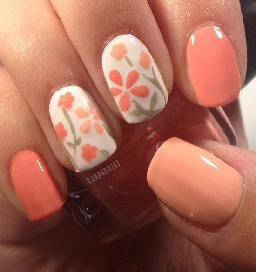

In [ ]:
img_aug_LEFT_RIGHT = Image.fromarray(X_train[1].astype('uint8')).transpose(Image.FLIP_LEFT_RIGHT) # Зеркальное отражение по горизонтали
img_aug_LEFT_RIGHT

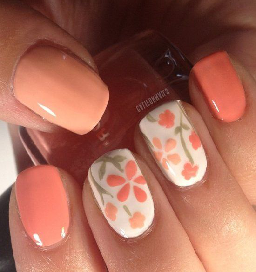

In [ ]:
img_aug_TOP_BOTTOM = Image.fromarray(X_train[1].astype('uint8')).transpose(Image.FLIP_TOP_BOTTOM) # Зеркальное отражение по вертикали
img_aug_TOP_BOTTOM

In [ ]:
# Аугментация Y_train
cur_time = time.time()
num_classes = 2
Y_train_aug = []
for idx in range(len(Y_train)):
  yr = Y_train[idx].reshape(-1, 2)
  pr2 = []
  for k in range(len(yr)): # Проходим по всем уровням (количество классов)
    pr2.append(index2color(yr[k])) # Переводим индекс в пиксель
  pr2 = np.array(pr2) # Преобразуем в numpy
  pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
  ita_1 = image.img_to_array(Image.fromarray(pr2.astype('uint8')).transpose(Image.FLIP_LEFT_RIGHT))
  Y_train_aug.append(ita_1)
  ita_2 = image.img_to_array(Image.fromarray(pr2.astype('uint8')).transpose(Image.FLIP_TOP_BOTTOM))
  Y_train_aug.append(ita_2)

Y_train_aug = yt_prep(Y_train_aug, num_classes)
print(Y_train_aug.shape)
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы
beep()

100
200
300
400
500
600
700
800
(886, 272, 256, 2)
Время обработки:  951.64 c


In [ ]:
# Собираем x_train и y_train
xTrain = np.concatenate([X_train, X_train_aug], axis=0)
yTrain = np.concatenate([Y_train, Y_train_aug], axis=0)

In [ ]:
# Разбиваем на обучающую и проверочную выборки
# и сохраняем на диске, чтобы при послеюдущих входах в ноутбук не формировать выборки заново
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1)
np.save('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/sampling/x_train_fin', x_train)
np.save('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/sampling/x_val_fin', x_val)
np.save('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/sampling/y_train_fin', y_train)
np.save('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/sampling/y_val_fin', y_val)
beep()

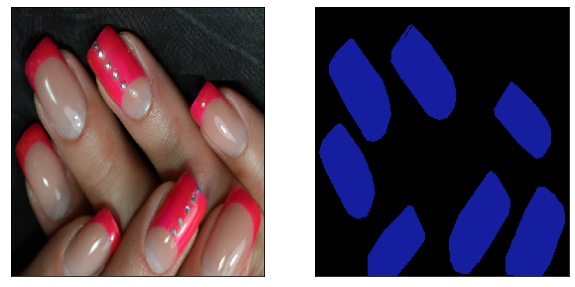

In [ ]:
# пример исходного и сегментированного y_train-изображения
idx = random.randint(0, len(x_train))
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 6)) #Создаем полотно из n графиков
yr = y_train[idx].reshape(-1, 2)
pr2 = []
for k in range(len(yr)): # Проходим по всем уровням (количество классов)
  pr2.append(index2color(yr[k])) # Переводим индекс в пиксель
pr2 = np.array(pr2) # Преобразуем в numpy
pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
plt.xticks([])
plt.yticks([])
axs[0].imshow(Image.fromarray(x_train[idx].astype('uint8'))) # Отображаем на графике в первой линии
axs[1].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal

#Функции обучения и проверки

In [ ]:
#При новом вхождении в ноутбук загружаем параметры, выборки и нужные функции
img_width = 272
img_height= 256
num_classes = 2

x_train = np.load('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/sampling/x_train_fin.npy')
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/sampling/y_train_fin.npy')
x_val = np.load('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/sampling/x_val_fin.npy')
y_val = np.load('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/sampling/y_val_fin.npy')

# Функция звукового сигнала выполнения ячейки
def beep():
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
beep()

# Собственная функция метрики, обрабатывающая пересечение двух областей
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

# Никита Серов: "Советую ... поменять функцию ошибки на dice_loss (dice_loss = 1 - dice_coef)"
def dice_loss(y_true, y_pred):
    return (1-(2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

# Функция преобразования индекса в цвет пикселя
def index2color(index2):
    index = np.argmax(index2)
    color=[]
    if index == 0:
        color = [0, 0, 0]  # чёрный фон
    elif index == 1:
        color = [20, 30, 158]    # область ногтей
    return color

# Функция преобразования индекса в цвет пикселя - новый цвет маникюра
def index2color2(index2, img_test_2, k, color_new):
    index = np.argmax(index2)
    color=[]
    if index == 0:
        color = [int(img_test_2[k][0]), int(img_test_2[k][1]), int(img_test_2[k][2])]  # формирует изображение вне области ногтей
    elif index == 1:
        color = color_new # новый цвет маникюра на области ногтей
    return color

# Функция визуализации результатов обучения
def processImage(model, n_classes, n_img):
    indexes = np.random.randint(0, len(x_val), n_img) # Получаем n_classes случайных индексов
    fig, axs = plt.subplots(3, n_img, sharex=True, sharey=True, figsize=(20, 12)) #Создаем полотно из n графиков
    plt.xticks([]) # Убираем шкалу оси
    plt.yticks([]) # Убираем шкалу оси
    for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
        predict = np.array(model.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # Предиктим картинку
        pr = predict[0] # Берем нулевой элемент из предикта
        pr1 = [] # Пустой лист под сегментированную картинку из predict'a
        pr2 = [] # Пустой лист под сегментированную картинку из yVal
        pr = pr.reshape(-1, n_classes) # Решейпим предикт
        yr = y_val[idx].reshape(-1, n_classes) # Решейпим yVal
        for k in range(len(pr)): # Проходим по всем уровням (количество классов)
            pr1.append(index2color(pr[k])) # Переводим индекс в пиксель
            pr2.append(index2color(yr[k])) # Переводим индекс в пиксель
        pr1 = np.array(pr1) # Преобразуем в numpy
        pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
        pr2 = np.array(pr2) # Преобразуем в numpy
        pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
        img = Image.fromarray(pr1.astype('uint8')) # Получаем картинку из предикта
        axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
        axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
        axs[2,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение

# Функция модели и callback'а

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unetWithMask_fin(num_classes,
                        input_shape,
                        activation
                        ):
    img_input = Input(input_shape)                                      # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation(activation)(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out

    x11 = Conv2D(32, (3, 3), padding='same', name='block1_conv3')(block_1_out)      # Добавляем Conv2D-слой в блок из 3х слоёв к пробросу
    x11 = BatchNormalization()(x11)                                         # Добавляем слой BatchNormalization
    x11 = Activation(activation)(x11)

    x12 = Conv2D(16, (3, 3), padding='same', name='block1_conv4')(block_1_out)      # Добавляем Conv2D-слой в блок из 3х слоёв к пробросу
    x12 = BatchNormalization()(x12)                                         # Добавляем слой BatchNormalization
    x12 = Activation(activation)(x12)

    x13 = Conv2D(8, (3, 3), padding='same', name='block1_conv5')(block_1_out)      # Добавляем Conv2D-слой в блок из 3х слоёв к пробросу
    x13 = BatchNormalization()(x13)                                         # Добавляем слой BatchNormalization
    x13 = Activation(activation)(x13)

    concat_x1 = concatenate([x11, x12, x13])                                #Конкатенируем 3 слоя

    block_1_out_mask = Conv2D(64, (1, 1), padding='same')(concat_x1)  # Добавляем concat_x к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out) # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x) # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation(activation)(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    x21 = Conv2D(32, (3, 3), padding='same', name='block2_conv3')(block_2_out)      # Добавляем Conv2D-слой в блок из 3х слоёв к пробросу
    x21 = BatchNormalization()(x21)                                         # Добавляем слой BatchNormalization
    x21 = Activation(activation)(x21)

    x22 = Conv2D(16, (3, 3), padding='same', name='block2_conv4')(block_2_out)      # Добавляем Conv2D-слой в блок из 3х слоёв к пробросу
    x22 = BatchNormalization()(x22)                                         # Добавляем слой BatchNormalization
    x22 = Activation(activation)(x22)

    x23 = Conv2D(8, (3, 3), padding='same', name='block2_conv5')(block_2_out)      # Добавляем Conv2D-слой в блок из 3х слоёв к пробросу
    x23 = BatchNormalization()(x23)                                         # Добавляем слой BatchNormalization
    x23 = Activation(activation)(x23)

    concat_x2 = concatenate([x21, x22, x23])                                #Конкатенируем 3 слоя

    block_2_out_mask = Conv2D(128, (1, 1), padding='same')(concat_x2) # Добавляем concat_x к текущему слою и запоминаем в переменную block_2_out_mask

    x = MaxPooling2D()(block_2_out)                                     # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation(activation)(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    x31 = Conv2D(32, (3, 3), padding='same', name='block3_conv3')(block_3_out)      # Добавляем Conv2D-слой в блок из 3х слоёв к пробросу
    x31 = BatchNormalization()(x31)                                         # Добавляем слой BatchNormalization
    x31 = Activation(activation)(x31)

    x32 = Conv2D(16, (3, 3), padding='same', name='block3_conv4')(block_3_out)      # Добавляем Conv2D-слой в блок из 3х слоёв к пробросу
    x32 = BatchNormalization()(x32)                                         # Добавляем слой BatchNormalization
    x32 = Activation(activation)(x32)

    x33 = Conv2D(8, (3, 3), padding='same', name='block3_conv5')(block_3_out)      # Добавляем Conv2D-слой в блок из 3х слоёв к пробросу
    x33 = BatchNormalization()(x33)                                         # Добавляем слой BatchNormalization
    x33 = Activation(activation)(x33)

    concat_x3 = concatenate([x31, x32, x33])                                #Конкатенируем 3 слоя

    block_3_out_mask = Conv2D(256, (1, 1), padding='same')(concat_x3) # Добавляем concat_x к текущему слою и запоминаем в переменную block_3_out_mask

    x = MaxPooling2D()(block_3_out)                                     # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation(activation)(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    x41 = Conv2D(32, (3, 3), padding='same', name='block4_conv3')(block_4_out)      # Добавляем Conv2D-слой в блок из 3х слоёв к пробросу
    x41 = BatchNormalization()(x41)                                         # Добавляем слой BatchNormalization
    x41 = Activation(activation)(x41)

    x42 = Conv2D(16, (3, 3), padding='same', name='block4_conv4')(block_4_out)      # Добавляем Conv2D-слой в блок из 3х слоёв к пробросу
    x42 = BatchNormalization()(x42)                                         # Добавляем слой BatchNormalization
    x42 = Activation(activation)(x42)

    x43 = Conv2D(8, (3, 3), padding='same', name='block4_conv5')(block_4_out)      # Добавляем Conv2D-слой в блок из 3х слоёв к пробросу
    x43 = BatchNormalization()(x43)                                         # Добавляем слой BatchNormalization
    x43 = Activation(activation)(x43)

    concat_x4 = concatenate([x41, x42, x43])                                #Конкатенируем 3 слоя

    block_4_out_mask = Conv2D(512, (1, 1), padding='same')(concat_x4) # Добавляем concat_x к текущему слою и запоминаем в переменную block_4_out_mask (вместо (x) было (concat_x4))

    x = MaxPooling2D()(block_4_out)                                     # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    # UP 1
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                           # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                          # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation(activation)(x)                                          # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x) # Добавляем Conv2D-Слой с sigmoid-активацией на num_classes-нейронов

    model = Model(img_input, x)                                        # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=[dice_loss])

    return model                                                       # Возвращаем сформированную модель

activation = 'relu'

In [ ]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # Атрибут best_weights для хранения весов, при которых достигнуто минимальное значение лосс-функции
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # Количество эпох, в течение которых значение лосс-фунции больше минимального
        self.wait = 0
        # Эпоха, на которой останавливается обучение
        self.stopped_epoch = 0
        # Лучшее текущее минимальное значение лосс-функции равно бесконечности
        self.best = np.Inf
        self.lr = round(float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)), 3)

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_dice_loss')
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Запись лучших весов (если текущие результаты лучше, т.е. меньше)
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
            if self.wait >= self.patience-5:
              if self.lr == 0.001:
                tf.keras.backend.set_value(self.model.optimizer.lr, round(self.lr/10, 4))
                self.lr = round(float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)), 4)
                print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, self.lr))

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
        print("Epoch with best val_dice_loss:  %05d" % (self.best_epoch + 1))
        print("val_dice_loss:", self.best)

# Обучение

In [ ]:
unetWithMask_fin(num_classes, (img_width, img_height,3), activation).summary() #summary-модель

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 272, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 272, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 272, 256, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

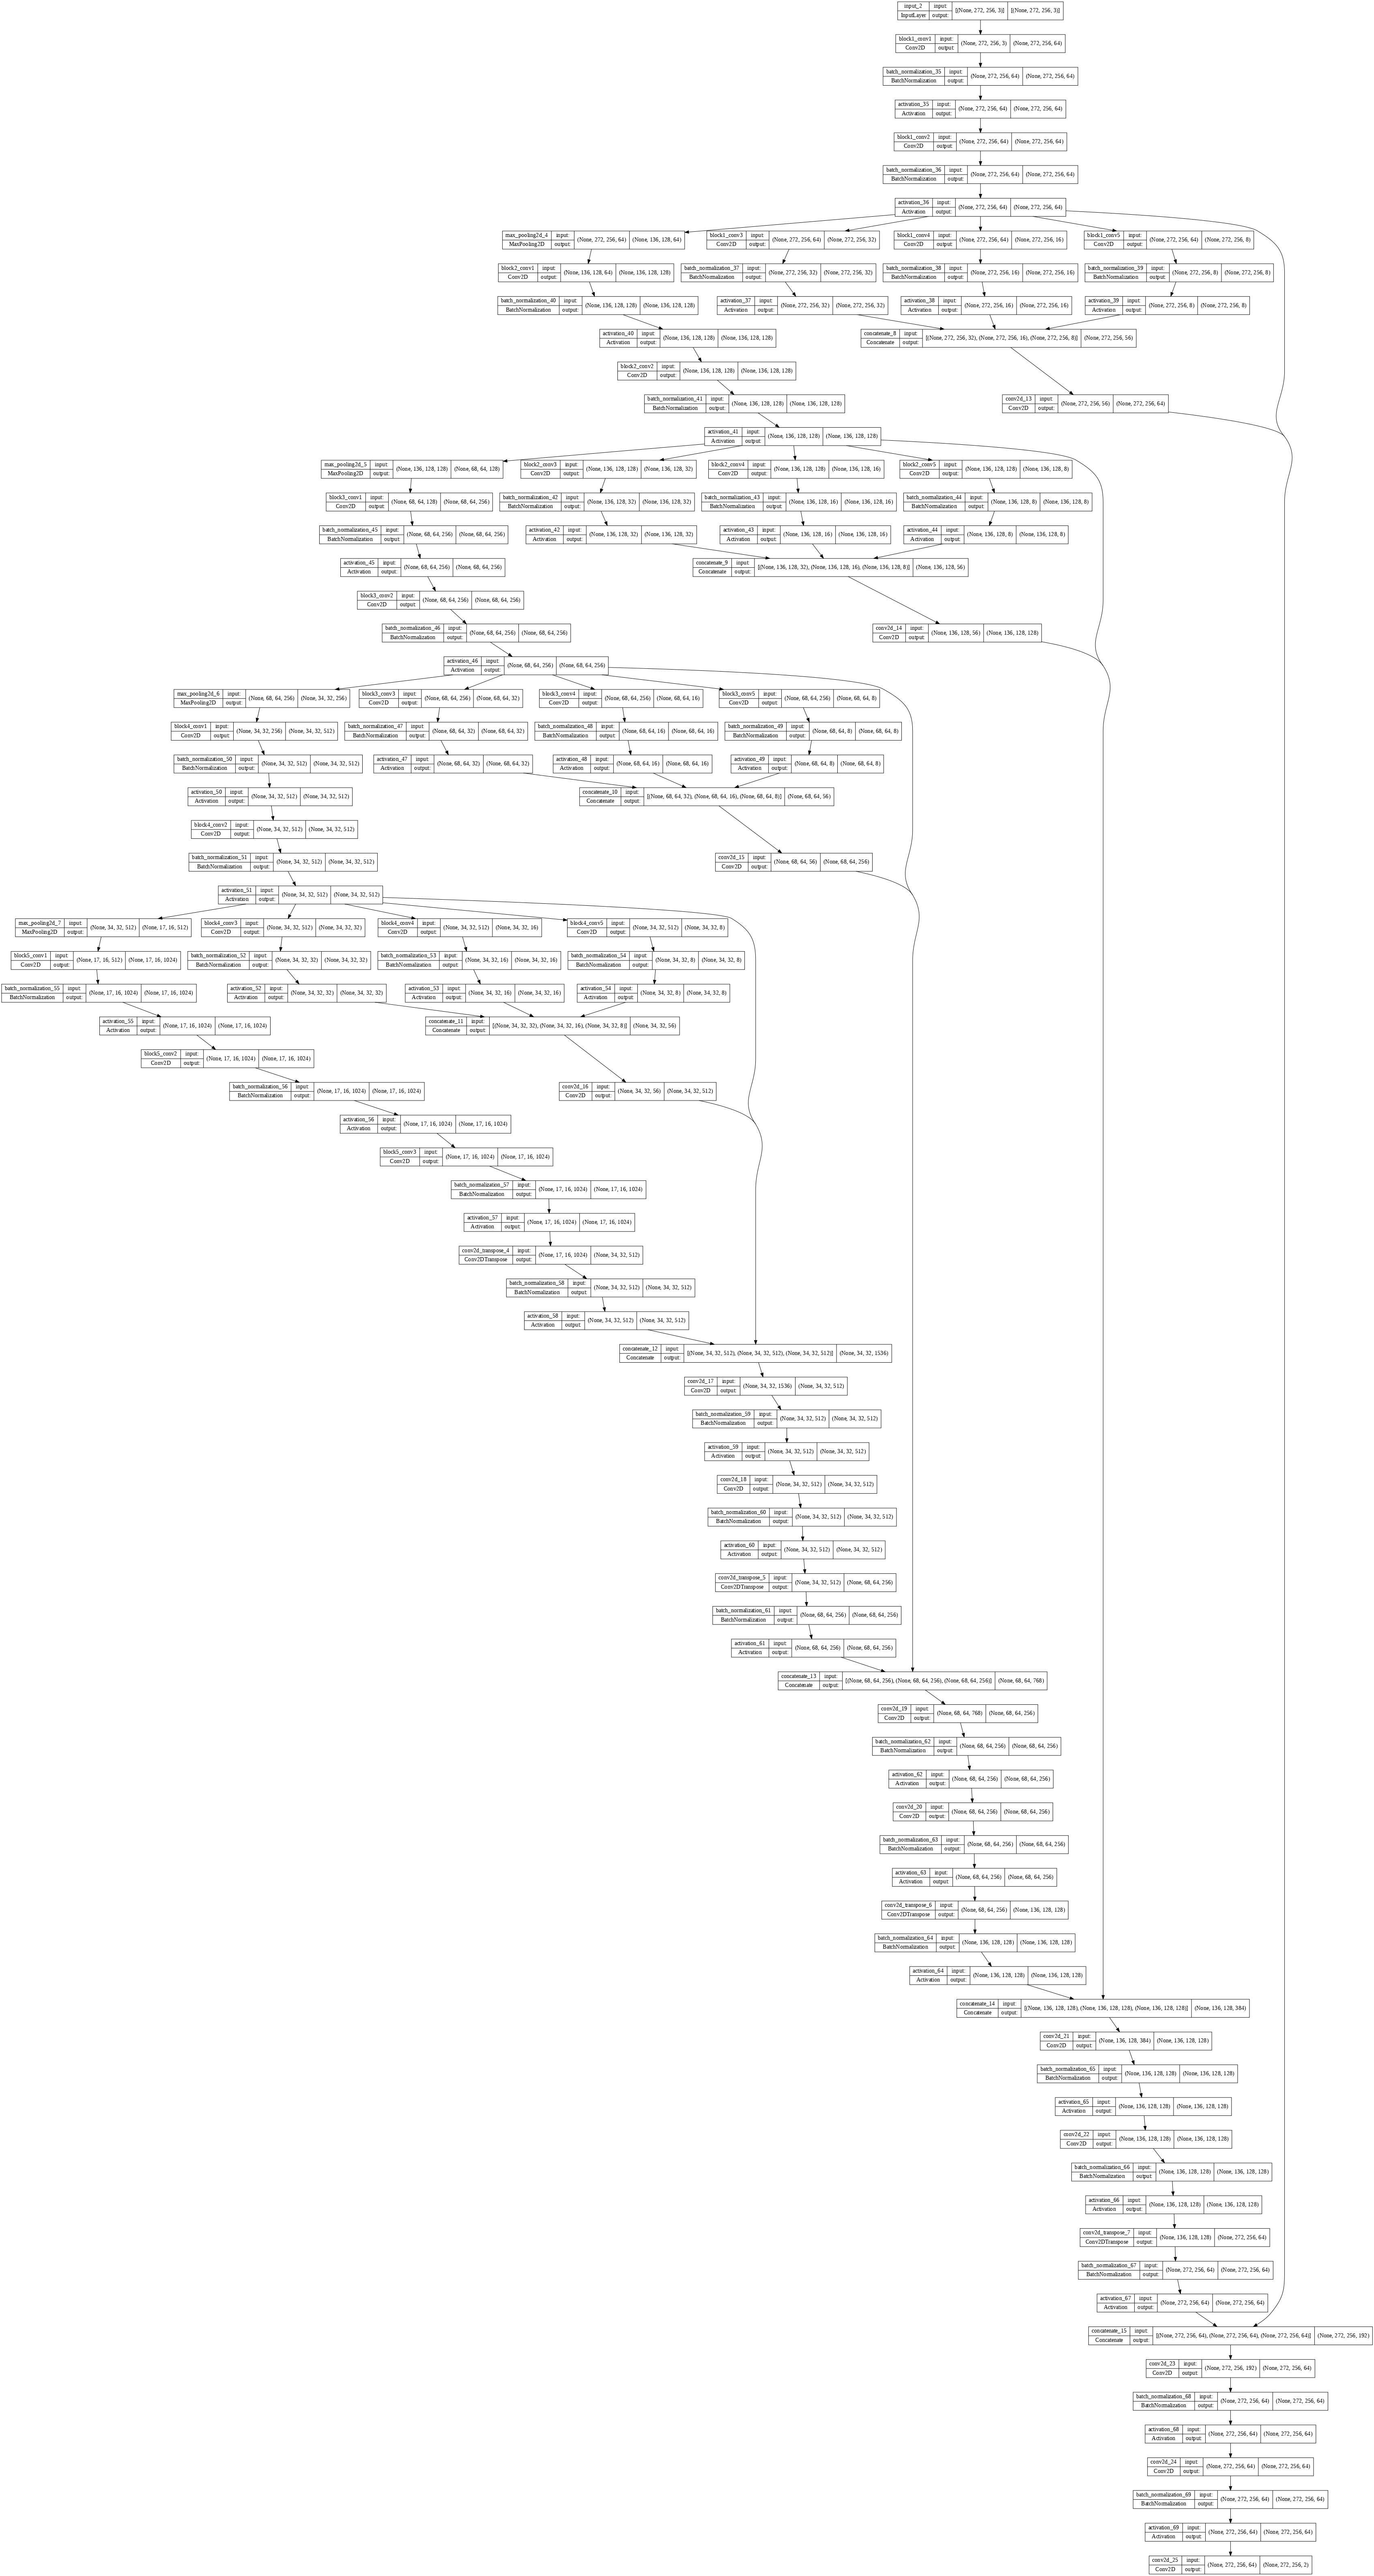

In [ ]:
plot_model(unetWithMask_fin(num_classes, (img_width, img_height,3), activation), dpi=70, show_shapes=True) # Архитектура модели

Epoch 1/100
150/150 [==============================] - 157s 882ms/step - loss: 0.2559 - dice_loss: 0.1523 - val_loss: 11.1016 - val_dice_loss: 0.7260
Epoch 2/100
150/150 [==============================] - 125s 832ms/step - loss: 0.1812 - dice_loss: 0.1052 - val_loss: 0.2655 - val_dice_loss: 0.1233
Epoch 3/100
150/150 [==============================] - 128s 856ms/step - loss: 0.1406 - dice_loss: 0.0810 - val_loss: 0.1521 - val_dice_loss: 0.0628
Epoch 4/100
150/150 [==============================] - 130s 864ms/step - loss: 0.0983 - dice_loss: 0.0559 - val_loss: 0.0907 - val_dice_loss: 0.0434
Epoch 5/100
150/150 [==============================] - 131s 875ms/step - loss: 0.0771 - dice_loss: 0.0437 - val_loss: 0.0798 - val_dice_loss: 0.0367
Epoch 6/100
150/150 [==============================] - 131s 871ms/step - loss: 0.0690 - dice_loss: 0.0384 - val_loss: 0.0750 - val_dice_loss: 0.0370
Epoch 7/100
150/150 [==============================] - 131s 873ms/step - loss: 0.0614 - dice_loss: 0.0341

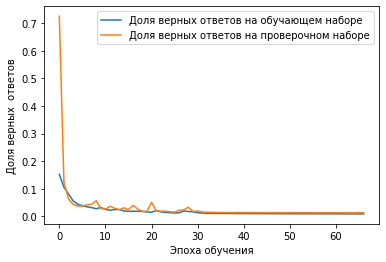

In [ ]:
# Запускаем обучение
cur_time = time.time()
activation = 'relu'
bs8_relu_ep100_model_aug_fin = unetWithMask_fin(num_classes, (img_width, img_height,3), activation)
history = bs8_relu_ep100_model_aug_fin.fit(x_train, y_train, epochs=100, batch_size=8, validation_data = (x_val, y_val), callbacks=[EarlyStoppingAtMinLoss(10)]) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

time_train = round(time.time() - cur_time, 2)
print('Время обучения: ', time_train,'c')

bs8_relu_ep100_model_aug_fin.save_weights('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/models/bs8_relu_ep100_model_aug_fin.h5') # Сохраняем веса модели
bs8_relu_ep100_model_aug_fin_vdl = pd.DataFrame([history.history['val_dice_loss']]) # Сохраняем значения val_dice_loss
bs8_relu_ep100_model_aug_fin_vdl.to_csv('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/models/bs8_relu_ep100_model_aug_fin_vdl.csv') # Сохраняем val_dice_loss в csv

#Оображаем график точности обучения
plt.plot(history.history['dice_loss'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_dice_loss'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных  ответов')
plt.legend()
plt.show()

beep()

# Результаты обучения

In [ ]:
# При новом вхождении в ноутбук загружаем модель и веса
test_model = unetWithMask_fin(num_classes, (img_width, img_height,3), activation) # Задаём архитектуру и параметры модели
test_model.load_weights('/content/drive/MyDrive/Colab Notebooks/01 ДИПЛОМ/models/bs8_relu_ep100_model_aug_fin.h5') # Задаём веса модели

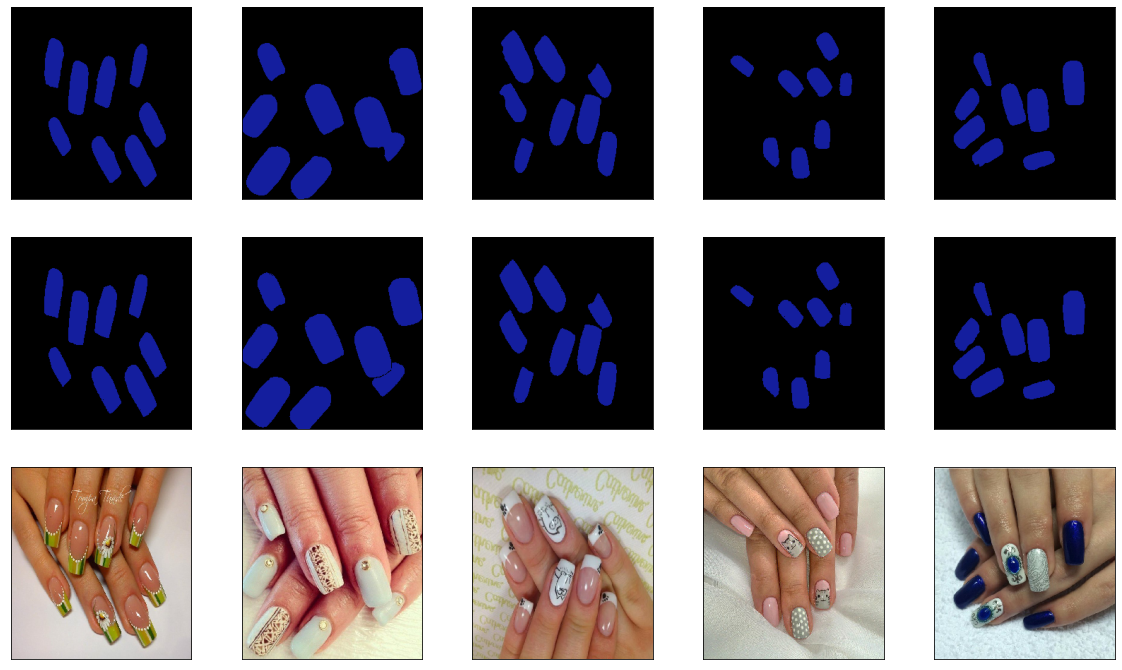

In [ ]:
# Распознавание
processImage(test_model, 2, 5) # Функция отображения результатов обучения

# Тест модели - наложение нового цвета маникюра на тестовое изображение

In [ ]:
# Функция тестирования модели
def test_model_func():
  predict = np.array(test_model.predict(image.img_to_array(img_test).reshape(1, img_width, img_height, 3))) # Предиктим тестовое изображение
  pr = predict[0] # Берем нулевой элемент из предикта
  pr = pr.reshape(-1, num_classes) # Решейпим предикт в 2-мерный массив (69632, 3)
  pr1 = [] # Пустой лист под сегментированную изображение из predict'a

  img_test_2 = image.img_to_array(img_test) # Переводим тестовое изображение в numpy
  img_test_2 = img_test_2.reshape(-1, 3) # Решейпим тестовое изображение в 2-мерный массив (69632, 3)
  img_test_result = [] # Список для нового изображения с новым цветом маникюра

  for k in range(len(pr)): # Проходим по всем уровням (количество классов)
      pr1.append(index2color(pr[k])) # Переводим индекс в пиксель
      img_test_result.append(index2color2(pr[k], img_test_2, k, color_new)) # Переводим индекс в пиксель

  pr1 = np.array(pr1) # Преобразуем предикт в numpy
  pr1 = pr1.reshape(img_width, img_height,3) # Решейпим предикт к размеру изображения
  img = Image.fromarray(pr1.astype('uint8')) # Получаем изображение из предикта

  img_test_result = np.array(img_test_result) # Преобразуем изображение с новым цветом маникюра в numpy
  img_test_result = img_test_result.reshape(img_width, img_height, 3) # Решейпим к размеру изображения
  img_test_result = Image.fromarray(img_test_result.astype('uint8')) # Получаем изображение с новым цветом маникюра

  plt.figure(1, figsize=(15,7)) #Создаем полотно для изображений

  plt.subplot(131) # Отображаем Исходное изображение
  plt.imshow(img_test)
  plt.title('Исходное изображение')
  plt.axis('off')

  plt.subplot(132) # Отображаем Predict
  plt.imshow(img.convert('RGBA'))
  plt.title('Predict')
  plt.axis('off')

  plt.subplot(133) # Отображаем Изображение с новым цветом маникюра
  plt.imshow(img_test_result.convert('RGBA'))
  plt.title('Изображение с новым цветом маникюра')
  plt.axis('off')

  plt.show() # Отображаем полотно

Saving img_test_load.png to img_test_load.png


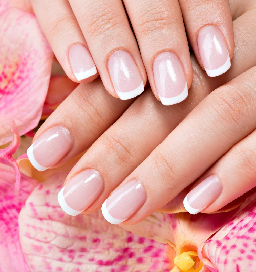

In [ ]:
# Загружаем фото маникюра, скаченное из интернета, которое модель ни видела
files.upload() # Функция загрузки внешних файлов
img_test = image.load_img('/content/img_test_load.png', target_size=(img_width, img_height)) # Передаём фото, загруженное на диск, в переменную
img_test # Отображаем фото

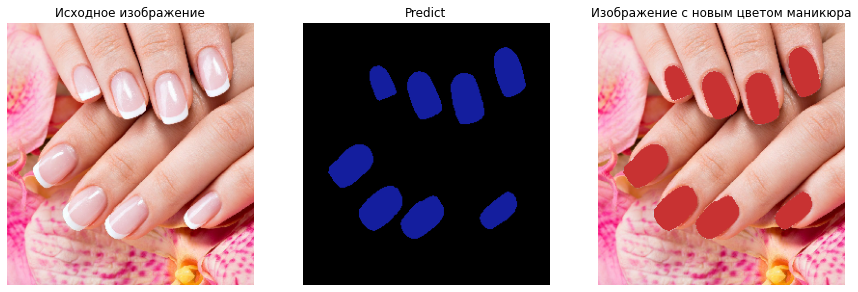

In [ ]:
# Тестирование модели
color_new = [200, 50, 50] # новый цвет маникюра https://csscolor.ru/ или https://tools.seo-zona.ru/color.html
test_model_func()